In [60]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10, 3)

In [61]:
import pandas as pd

In [62]:
MAN_HEIGHT_M = 1.7
EARTH_GRAVITY = 9.81
ACCELERATION_ERROR = .7 * EARTH_GRAVITY
VELOCITY_ERROR = 0.5
BOUNDING_BOX_SCALE_FACTOR = 0.7

# Load data

In [63]:
df = pd.read_pickle('boxes_2.df')
len(df)

233

# Transform data

In [64]:
def scale_box(box, f):
    (x, y, w, h) = box
    return x + int(.5 * w * (1 - f)), y + int(.5 * h * (1 - f)), w * f, h * f


def bigger_box(box):
    f = 1 / BOUNDING_BOX_SCALE_FACTOR
    return scale_box(box, f)

In [65]:
df.box = df.box.apply(lambda box: bigger_box(box))

In [66]:
m_to_p_ratio = MAN_HEIGHT_M / df.box.head(1).item()[3]
m_to_p_ratio

0.002901428073841867

In [67]:
df.index = pd.to_datetime(df.index, unit='ms')
df['y'] = df.box.apply(lambda r: - r[1] * m_to_p_ratio)

<AxesSubplot:title={'center':'Vertical position in meters'}>

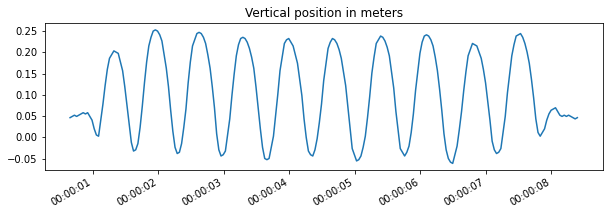

In [68]:
df.y.plot(title='Vertical position in meters')

# $\tilde{y}$,$\dot{y}$,$\ddot{y}$

In [94]:
INTERPOLATION_SPAN = 50

<AxesSubplot:title={'center':'Resampled, interpolated and smoothed position'}>

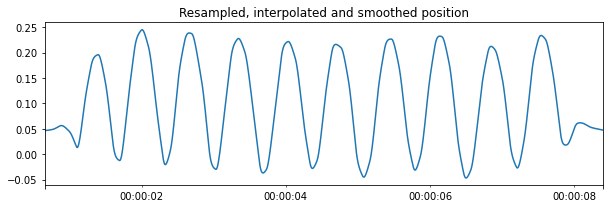

In [95]:
interpolated = df.y.resample('1L').interpolate()
# interpolated.plot()
smoothed = interpolated.ewm(span=.5 * INTERPOLATION_SPAN).mean()
smoothed.plot(title="Resampled, interpolated and smoothed position")

<AxesSubplot:title={'center':'Velocity'}>

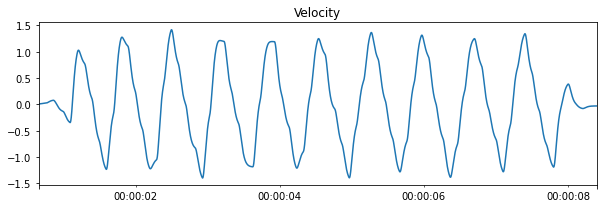

In [96]:
velocity = (smoothed.diff() * 1000).ewm(span=INTERPOLATION_SPAN).mean()
velocity.plot(title="Velocity")

<AxesSubplot:title={'center':'Acceleration'}>

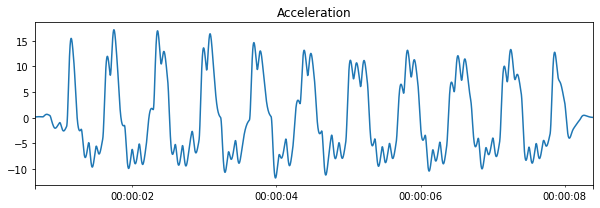

In [97]:
acceleration = (velocity.diff() * 1000).ewm(span=INTERPOLATION_SPAN).mean()
# acceleration = (velocity.diff() * 1000).rolling(window=5*INTERPOLATION_SPAN).min()
# (velocity.diff() * 1000).plot()
acceleration.plot(title='Acceleration')

In [98]:
df = pd.DataFrame({
    'y': smoothed,
    'v': velocity,
    'a': acceleration.shift(-20)
})
df.to_csv('data.csv')

# Detect

In [99]:
df['freefall'] = ((df.a + EARTH_GRAVITY).abs() < ACCELERATION_ERROR)
# df['still'] = (df.v.abs() < VELOCITY_ERROR)
df['local_maximum'] = ((df.y.shift(1) < df.y) & (df.y.shift(-1) <= df.y))

<AxesSubplot:title={'center':'Jump detections and vertical position'}>

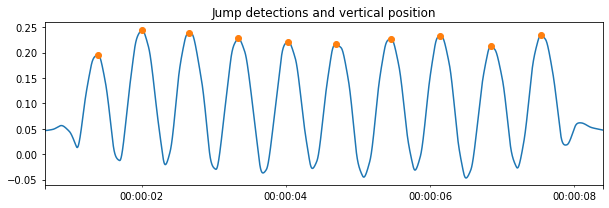

In [100]:
# ((df.freefall & df.local_maximum).astype(float) * 0.3).plot(marker='o')
smoothed.plot(title='Jump detections and vertical position')
(df[(df.freefall & df.local_maximum)].y).plot(marker='o', linestyle = 'None')

<AxesSubplot:>

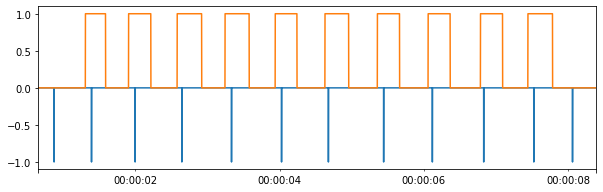

In [76]:
(-df.local_maximum.astype(float)).plot()
df.freefall.astype(float).plot()